# k-means clustering

k-means is a kind of clustering algorithms, which belong to the family of [unsupervised machine learning](https://en.wikipedia.org/wiki/Unsupervised_learning) models. It aims at finding $k$ groups of similar data (clusters) in an unlabeled multidimensional dataset.


## The k-means minimization problem

Let $(x_1, ..., x_n)$ be a set of $n$ observations with $x_i \in \mathbb{R}^{d}$, for $1 \leq i \leq n$. The aim of the k-means algorithms is to find a disjoint partition $S=\{S_1, ..., S_k \}$ of the $n$ observations into $k \leq n$ clusters, minimizing $D$ the within-cluster distance to center:
$$ D(S) = \sum_{i=1}^k \sum_{x \in S_i} \| x - \mu_i \|^2 $$
where $\mu_i$ is the $i$-th cluster center (i.e. the arithmetic mean of the cluster observations): $\mu_i = \frac{1}{|S_i|} \sum_{x_j \in S_i} x_j$, for $1 \leq i \leq n$.

Unfortunately, finding the exact solution of this problem is very tough (NP-hard) and a local minimum is generally sought using a heuristic.

## The algorithm

Here is a simple description of the algorithm taken from the book ["Data Science from Scratch"](http://shop.oreilly.com/product/0636920033400.do) by Joel Grus (O'Reilly):

1. Start with a set of k-means, which are $k$ points in $d$-dimensional space.
2. Assign each point to the mean to which it is closest.
3. If no point’s assignment has changed, stop and keep the clusters.
4. If some point’s assignment has changed, recompute the means and return to step 2.

This algorithm is an iterative refinement procedure. In his book ["Python Data Science Handbook"](http://shop.oreilly.com/product/0636920034919.do) (O'Reilly), Jake VanderPlas refers to this algorithm as kind of Expectation–Maximization (E–M). Since step 1 is the algorithm initialization and step 3 the stopping criteria, we can see that the algorithm consists in only two alternating steps:

step 2. is the *Expectation*: 
> "updating our expectation of which cluster each point belongs to".

step 4. is the *Maximization*:
> "maximizing some fitness function that defines the location of the cluster centers".

This is described with more details in the following [link](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html).

An interesting geometrical interpretation is that step 2 corresponds to partitioning the observations according to the Voronoi diagram generated by the centers computed previously (either on step 1 or 4). This is also why the standard k-means algorithm is also called Lloyd's algorithm, which is a Voronoi iteration method for finding evenly spaced sets of points in subsets of Euclidean spaces.

### Voronoi diagram

Let us have a look at the Voronoi diagram generated by the $k$ means.

As in Jake VanderPlas' book, we generate some fake observation data using scikit-learn 2-dimensional blobs, in order to easily plot them.

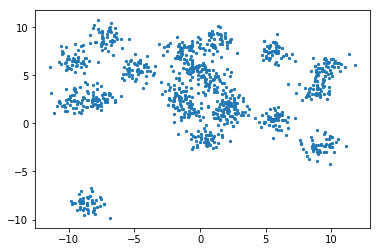

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

k = 20
n = 1000
X, _ = make_blobs(n_samples=n, centers=k, cluster_std=0.70, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=5);

The k-means implementation from scikit-learn is used in the following, in order to compute the clusters and the centers:

#### Iteration #1

A single E-M iteration is performed in the following:

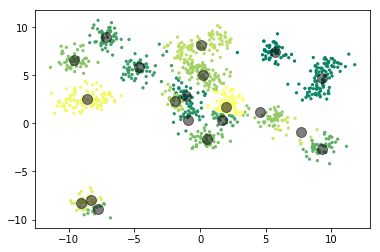

In [2]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=0, max_iter=1)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)  # cluster index for each observation

centers = kmeans.cluster_centers_  # cluster center coordinates
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

Now we compute the Voronoi diagram generated by the centers with scipy and observe that data is partitioned according to this diagram.

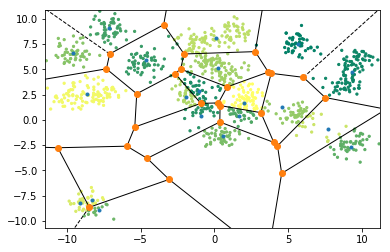

In [3]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(centers)
voronoi_plot_2d(vor)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer')
plt.show()

#### At "convergence"

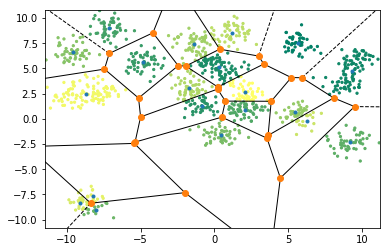

In [4]:
kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=0, max_iter=1000)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)  # cluster index for each observation
centers = kmeans.cluster_centers_  # cluster center coordinates
vor = Voronoi(centers)
voronoi_plot_2d(vor)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer')
plt.show()

Note that once the `fit` method from scikit-learn has been called, the `predict` one will just assign the given points to the closest centers computed in the fitting step.

### Initialization

The initialization step 1 is very important for the algorithm to perform well, especially because only a local optimum is reached at the end, which strongly depends on the starting point. The initialization method used above is the Random Partition, which randomly assigns a cluster to each observation, thus placing all means close to the center of the data set. As stated by Jake VanderPlas:
> "[...] although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results."

Some methods have been proposed to initialize the means in order to guarentee that the algorithm will reach a "correct" solution, such as [K-means++](https://en.wikipedia.org/wiki/K-means%2B%2B), which is the default initialization method of sklearn.cluster.KMeans:

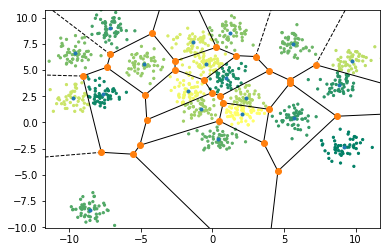

In [5]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)  # cluster index for each observation
centers = kmeans.cluster_centers_  # cluster center coordinates
vor = Voronoi(centers)
voronoi_plot_2d(vor)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer')
plt.show()

Also, the method is usually performed several times (default is 10 times in scikit_learn) with different centroid seeds (different initializations). Only the best result is returned, in terms of within-cluster sum of squared $D(S)$, also called *inertia*.

In [6]:
print(kmeans.inertia_)

838.0594649998457


This inertia here is significantly better than the one we would get by using a single run of k-means (instead of 10) with a random partition initialization:

In [7]:
kmeans = KMeans(n_clusters=k, init='random', n_init=1, random_state=0)
kmeans.fit(X)
print(kmeans.inertia_)

1133.214871399982


### Computational considerations

Data sets are characterized by their cardinality $n$ and dimensionality $d$, among other things... 

When $d$ is "large", one may actually be dealing with a lot of zeros. An example of sparse observations can be found in [this](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html) case of text documents clustering by topics using a bag-of-words approach: same word occurences tend to be relatively infrequent throughout the corpus, which means that a lot of zeros would be found in the full numpy array representation. This is why a [compressed sparse row](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format) matrix format is used to store these data, and a special implementation of k-means algorithm for sparse data is implemented in scikit-learn. This allow to save some memory but also probably save some computational time.

When the data is not sparse, one may use the Elkan version , which uses the triangle inequality to accelerate the algorithm. The author states in [his](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) paper:

> Experiments show that the new algorithm is effective for datasets with up to 1000 dimensions, and becomes more and more effective as the number $k$ of clusters increases. For $k \geq 20$ it is many times faster than the best previously known accelerated k-means method.

If the algorithm (algorithm="elkan") does not support sparse data in scikit-learn, this is the default version when dealing with dense data, as we did above.

When dealing with large a large cardinality $n$, the [mini-batch k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) clustering should rather be used. [Here](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) is the paper introducing this algorithm that scales well when dealing with large data sets. This works for both sparse anf full input data format. As for the k-means algorithm, the initialization is run several times (10 by default), but not the algorithm, which is run only once.

Also, note that the scikit-learn implementation of k-means may be run in parallel, running each instance of k-means (algo + instance of initialization) on a thread.

### Pre-processing

It is important to keep in mind that k-means is based on distance calculation, which implies that the clusters will be influenced by the magnitudes of the variables, especially by outliers. It is usually recommended to standardize or unit-normalize each dimension individually. And one should be carefull when filling missing values.

Also, categorical variables must be replaced by numerical values: 
* integer encoding for ordinal variables
* one-hot encoding for cardinal variables

### Drawbacks

* $k$ has to be predefined, although it is possible to run k-means with a range of $k$ values and then select the one minimizing the overall clustering quality. Let us look at an example with the iris flower data set:

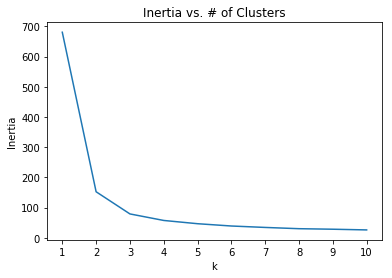

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target
target_names = ['setosa', 'versicolor', 'virginica']
df["Species"] = df.target.map(lambda i: target_names[i])

# loop on the number of clusters
n_k = 10
K = range(1, n_k + 1)
errors = np.zeros(n_k, dtype=float)
for i in range(len(K)):
    k = K[i]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']])
    errors[i] = kmeans.inertia_

plt.plot(K, errors)
plt.xticks(K)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Inertia vs. # of Clusters")
plt.show()

Actually, one can see an "elbow" around `k=3` in the above figure, which demarks significant drop in rate of decrease.  

k_means seems to be known for giving unsatisfatory results on the iris data set (see [wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set#/media/File:Iris_Flowers_Clustering_kMeans.svg)). The dataset has three distinct species, but here it seems that k-means does the job.

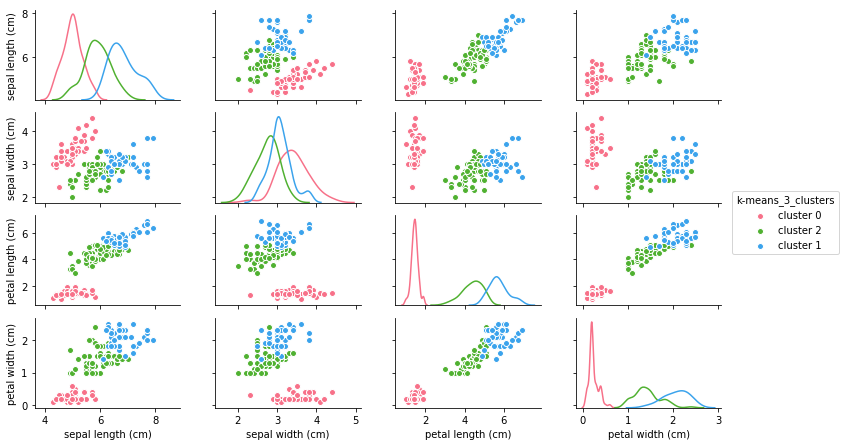

In [9]:
import seaborn as sns

kmeans = KMeans(n_clusters=3)
cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
kmeans.fit(df[cols])
df["k-means_3"] = kmeans.predict(df[cols])
df["k-means_3_clusters"] = df["k-means_3"].map(lambda i: "cluster "+str(i))

cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'k-means_3_clusters']
g1 = sns.pairplot(df[cols], hue="k-means_3_clusters", diag_kind="kde", palette="husl")
g1.fig.set_size_inches(12, 6)

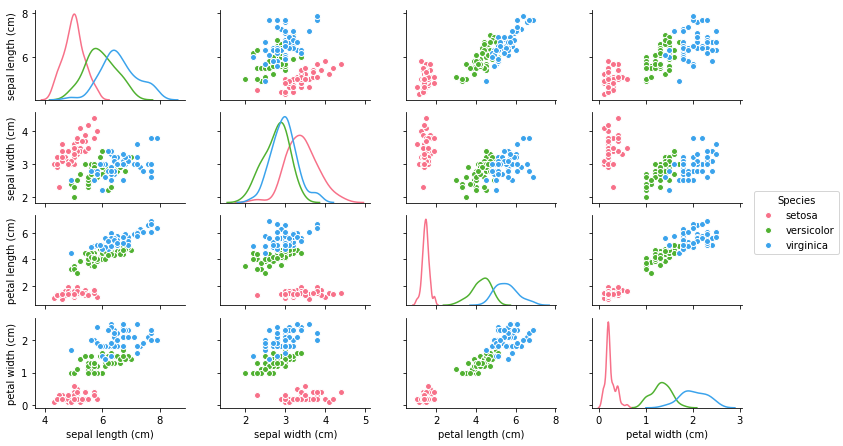

In [10]:
cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'Species']
g2 = sns.pairplot(df[cols], hue="Species", diag_kind="kde", palette="husl")
g2.fig.set_size_inches(12, 6)

* k-means clusters correspond to similar convex shapes. As stated in the book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) by Sarah Guido and Andreas Müller (O'Reilly):

> Each cluster is defined solely by its center, which means that each cluster is a convex shape. As a result of this, k-means can only capture relatively simple shapes. k-means also assumes that all clusters have the same “diameter” in some sense; it always draws the boundary between clusters to be exactly in the middle between the cluster centers.

* k-means can not deal with anisotropically distributed data or with complex shapes in general. Here are two examples taken from [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do):

Text(0,0.5,'Feature 1')

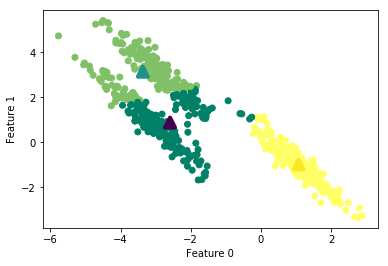

In [11]:
# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)
# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)

# cluster the data into three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)
# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='summer')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
marker='^', c=[0, 1, 2], s=100, linewidth=4)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0,0.5,'Feature 1')

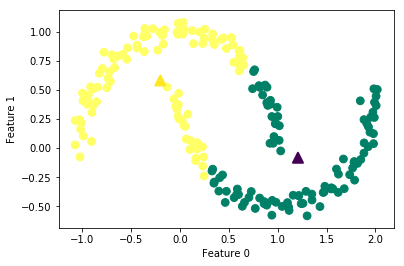

In [12]:
# generate synthetic two_moons data (with less noise this time)
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# cluster the data into two clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

# plot the cluster assignments and cluster centers
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='summer', s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
marker='^', s=100, c=[0, 1], linewidth=2)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

* *Curse of dimensionality*. From the scikit-learn documentation:
> Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.